# PROJECT TITLE:
# **Generating images based on the Fashion MNIST dataset**

# GOALS:
##- Generate images that are as close to the original Fashion MNIST images as possible using four models
##- Achieve diversity in the generated images (produce images of all ten classes)
##- Evaluate the four models

# METHODS - MODELS:
##- We will use four models (four different neural network architectures) to achieve our goal and then compare the generated images of these models.


# DATASET:
##- The Fashion MNIST dataset will be used for the training of these models.

In [1]:
# importing libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
plt.rcParams.update({'font.size': 12}) # a setting for the font size of texts in plt plots
import tensorflow as tf
import os
import time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# we download the dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist

# we will scale the data (pixel values) to [-1,1] range:
X_train_scaled = X_train/255*2-1
X_test_scaled = X_test/255*2-1

# and convert them to float32 format
X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)

In [3]:
# we will take a look at the shape of the X_train_scaled and y_train variables:
X_train_scaled.shape, y_train.shape

((60000, 28, 28), (60000,))

In [4]:
# the dataset consists of 70000 images of 28*28 pixels (grayscale) and their labels
# 60000 of these images are contained in the train dataset and 10000 in the test dataset
# Let's create a function that plots some random images from a set to get an idea
def plot_image(X, y, n_images, random_state=None):
    class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                   "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    images_per_row = 8
    n_rows = math.ceil(n_images / images_per_row)
    # set random seed if provided
    rng = np.random.default_rng(seed=random_state)
    indices = rng.choice(len(X), size=n_images, replace=False)
    plt.figure(figsize=(images_per_row/1.2, n_rows))
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(X[idx], cmap='binary')
        plt.title(class_names[y[idx]], fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

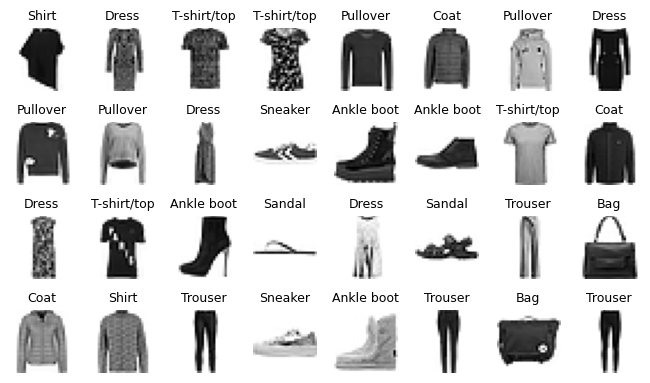

In [5]:
plot_image(X_train, y_train, 32, random_state=42)

In [6]:
# the dataset consists of 10 different classes.
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                   "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# let's calculate the percentages of appearance of each class to check if the dataset is balanced:
unique_values, counts = np.unique(y_train, return_counts=True)
print('Training label percentages:')
for val, count in zip(unique_values, counts):
    print(f"{class_names[val]}: {round(count/len(y_train)*100,2)}%")

Training label percentages:
T-shirt/top: 10.0%
Trouser: 10.0%
Pullover: 10.0%
Dress: 10.0%
Coat: 10.0%
Sandal: 10.0%
Shirt: 10.0%
Sneaker: 10.0%
Bag: 10.0%
Ankle boot: 10.0%


In [7]:
# as we see the dataset is completely balanced.

# **1) Generative Adversarial Network (GAN) model**
## -  A simple GAN with Dense layers
## - We will use only fully connected layers in the generator and discriminator


In [8]:
# we set the latent dimension
latent_dim = 100

# we create the generator
generator = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(latent_dim,)),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(28 * 28, activation="tanh"),
    tf.keras.layers.Reshape([28, 28, 1])
])

# we create the discriminator
discriminator = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# we first compile the discriminator and then the GAN model as follows
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False

# we connect the generator and discriminator to create the GAN pipeline
gan = tf.keras.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [9]:
# we add another 'weight-saving/loading' part in order to train the model incrementally multiple times
save_dir_gan = "/content/drive/MyDrive/gan_outputs"
epoch_file_path_gan = os.path.join(save_dir_gan, 'last_epoch.txt')

# Default to 0 if no record
if os.path.exists(epoch_file_path_gan):
    with open(epoch_file_path_gan, "r") as f:
        last_epoch = int(f.read())
else:
    last_epoch = 0

# we save the weights from each epoch separately so as to be able to return to
# whichever we choose
generator_weights_file_gan = os.path.join(save_dir_gan, f'generator_epoch_{last_epoch}.weights.h5')
discriminator_weights_file_gan = os.path.join(save_dir_gan, f'discriminator_epoch_{last_epoch}.weights.h5')

if os.path.exists(generator_weights_file_gan) and os.path.exists(discriminator_weights_file_gan):
    print(f"Loading weights from last saved epoch ({last_epoch})...")
    generator.load_weights(generator_weights_file_gan)
    discriminator.load_weights(discriminator_weights_file_gan)
else:
    print("No saved weights found. Starting from scratch.")

Loading weights from last saved epoch (50)...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
# We define a function that generates, plots and saves images given random noise as input
def plot_generated_images(generator, epoch, noise, save_dir='generated_images'):
    os.makedirs(save_dir, exist_ok=True)

    generated_images = generator(noise, training=False)
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(20/3, 10/3))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 8, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='binary')
        plt.axis('off')
    plt.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    # Show and save
    filepath = os.path.join(save_dir, f'epoch_{epoch:03d}.png')
    plt.savefig(filepath)
    plt.show()
    plt.close()


In [11]:
# We define a training function in order to incrementally train the model for some epochs
# The function checks if there are saved weights in the save_dir and loads them if it finds them
# It also generates and plots images after each epoch and saves them in the save_dir

def train_gan(gan, dataset, batch_size, latent_dim, n_epochs, d_update_interval=2,
              save_dir="/content/drive/MyDrive/gan_outputs"):
    import os
    import tensorflow as tf

    generator, discriminator = gan.layers
    os.makedirs(save_dir, exist_ok=True)

    # Path to track last epoch
    epoch_file_path = os.path.join(save_dir, 'last_epoch.txt')

    # Resume logic
    start_epoch = 0
    if os.path.exists(epoch_file_path):
        with open(epoch_file_path, "r") as f:
            start_epoch = int(f.read())

        gen_weights_path = os.path.join(save_dir, f'generator_epoch_{start_epoch}.weights.h5')
        disc_weights_path = os.path.join(save_dir, f'discriminator_epoch_{start_epoch}.weights.h5')

        if os.path.exists(gen_weights_path) and os.path.exists(disc_weights_path):
            print(f"Loading weights from epoch {start_epoch}...")
            generator.load_weights(gen_weights_path)
            discriminator.load_weights(disc_weights_path)
        else:
            print("Weight files missing. Starting from scratch.")
            start_epoch = 0

    step = 0

    for epoch in range(start_epoch, n_epochs):
        print(f'\nEpoch {epoch + 1}/{n_epochs}')
        disc_loss_total = 0.0
        disc_loss_steps = 0
        gen_loss_total = 0.0
        gen_loss_steps = 0
        for X_batch in dataset:
            # Train discriminator
            if step % d_update_interval == 0:
                noise = tf.random.normal([batch_size, latent_dim])
                generated_images = generator(noise)

                real_images = tf.cast(X_batch, tf.float32)
                real_images += tf.random.normal(shape=tf.shape(real_images), mean=0.0, stddev=0.1)

                X_fake_and_real = tf.concat([generated_images, real_images], axis=0)
                fake_labels = tf.random.uniform((batch_size, 1), minval=0.0, maxval=0.2)
                fake_labels = tf.zeros((batch_size, 1))
                real_labels = tf.random.uniform((batch_size, 1), minval=0.8, maxval=1.0)
                real_labels = tf.ones((batch_size, 1))
                y_fake_and_real = tf.concat([fake_labels, real_labels], axis=0)

                discriminator.trainable = True
                disc_loss = discriminator.train_on_batch(X_fake_and_real, y_fake_and_real, return_dict=True)

                disc_loss_total += disc_loss["loss"]
                disc_loss_steps += 1

            # Train generator
            noise = tf.random.normal([batch_size, latent_dim])
            y_generator = tf.random.uniform((batch_size, 1), minval=0.8, maxval=1.0)

            discriminator.trainable = False
            gan.train_on_batch(noise, y_generator)

            step += 1
            gen_loss = gan.train_on_batch(noise, y_generator, return_dict=True)
            gen_loss_total += gen_loss["loss"]
            gen_loss_steps += 1

        if disc_loss_steps > 0:
          avg_disc_loss = disc_loss_total / disc_loss_steps
          print(f"Epoch {epoch + 1} — Avg Discriminator Loss: {avg_disc_loss:.4f}")
        if gen_loss_steps > 0:
          avg_gen_loss = gen_loss_total / gen_loss_steps
          print(f"Epoch {epoch + 1} — Avg Generator Loss: {avg_gen_loss:.4f}")

        # Save model weights
        gen_weights_path = os.path.join(save_dir, f'generator_epoch_{epoch + 1}.weights.h5')
        disc_weights_path = os.path.join(save_dir, f'discriminator_epoch_{epoch + 1}.weights.h5')
        generator.save_weights(gen_weights_path)
        discriminator.save_weights(disc_weights_path)

        with open(epoch_file_path, "w") as f:
            f.write(str(epoch + 1))

        # Save sample images
        plot_generated_images(generator, epoch + 1, noise=seed, save_dir=save_dir)



In [12]:
# We will transform our dataset so as to fit with the required form for the model
# we will create batches of 32 images by slicing the training set
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_scaled.reshape(-1, 28,28,1)).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(X_test_scaled.reshape(-1, 28,28,1)).shuffle(buffer_size=1000)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [13]:
# Fixed noise (input) for monitoring progress
tf.random.set_seed(42)
seed = tf.random.normal([32, 100])

In [14]:
train_gan(gan, dataset, batch_size=32, latent_dim=100,
          n_epochs=50, d_update_interval=1, save_dir=save_dir_gan)

Loading weights from epoch 50...


In [15]:
# we will also create a function that visualizes some generated and some real images and has
# the discriminator predict the probability of the image being real
def visualize_fake_vs_real(generator, discriminator, real_dataset,
                           latent_dim=100, num_images=16, max_per_row=8, save_path=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import tensorflow as tf

    # Generate fake images
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
    fake_images = generator(random_latent_vectors, training=False)
    fake_logits = discriminator(fake_images, training=False)
    fake_preds = tf.squeeze(fake_logits).numpy()

    # Get real images
    real_images = []
    for batch in real_dataset:
        real_images.append(batch)
        if len(real_images) * batch.shape[0] >= num_images:
            break
    real_images = tf.concat(real_images, axis=0)[:num_images]
    real_images = (real_images - 0.5) * 2.0  # Scale from [0, 1] to [-1, 1]
    real_logits = discriminator(real_images, training=False)
    real_preds = tf.squeeze(real_logits).numpy()

    # Setup plotting grid
    rows = int(np.ceil(num_images / max_per_row))
    fig, axes = plt.subplots(
        nrows=rows * 2,
        ncols=max_per_row,
        figsize=(max_per_row * 1.3, rows * 2.2),
        gridspec_kw={'wspace': 0.1, 'hspace': 0.8})

    # Ensure axes is 2D
    if rows * 2 == 1:
        axes = np.expand_dims(axes, axis=0)
    elif max_per_row == 1:
        axes = np.expand_dims(axes, axis=1)

    # Plot all fake images first
    for idx in range(num_images):
        row = idx // max_per_row
        col = idx % max_per_row
        ax = axes[row][col]
        ax.imshow(fake_images[idx, :, :, 0], cmap='binary')
        ax.set_title(f"Fake: {fake_preds[idx]:.2f}", fontsize=10)
        ax.axis('off')

    # Plot all real images next
    for idx in range(num_images):
        row = (idx // max_per_row) + rows
        col = idx % max_per_row
        ax = axes[row][col]
        ax.imshow(real_images[idx, :, :, 0], cmap='binary')
        ax.set_title(f"Real: {real_preds[idx]:.2f}", fontsize=10)
        ax.axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.4)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


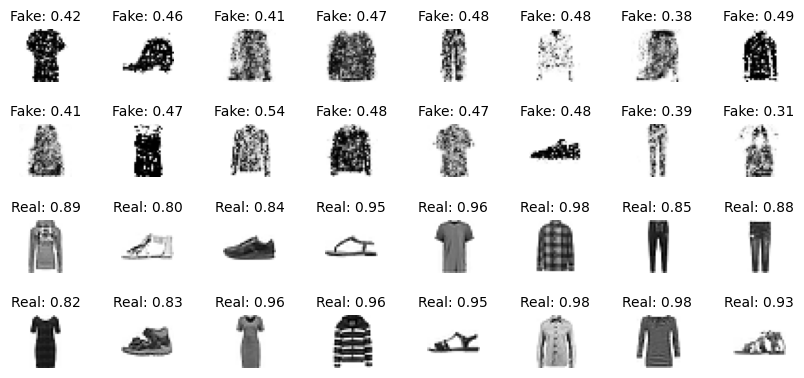

In [16]:
visualize_fake_vs_real(generator, discriminator, test_dataset, latent_dim=100, num_images=16)

#**2) Deep Convolutional Generative Adversarial Network (DCGAN) model**
## - In this model we use Convolutional layers (Conv2D) in the discriminator and Transposed Convolutional layers (Conv2DTranspose) in the generator

In [17]:
# we will use a helpful kernel initializer and LeakyReLU instead of ReLU to improve stability
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import LeakyReLU

initializer = RandomNormal(mean=0.0, stddev=0.02)

tf.random.set_seed(42)  # for reproducibility on CPU

latent_dim = 100

generator2 = tf.keras.Sequential([
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                    activation=LeakyReLU(0.2), kernel_initializer=initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                    activation="tanh", kernel_initializer=initializer)
])


discriminator2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2),
                           kernel_initializer=initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2),
                           kernel_initializer=initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=LeakyReLU(0.2)),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)
])

dcgan = tf.keras.Sequential([generator2, discriminator2])

In [18]:
# we compile the discrimator and the gan, as earlier
discriminator2.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator2.trainable = False
dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [19]:
# we define the save directory for dcgan
save_dir_dcgan = "/content/drive/MyDrive/dcgan_outputs"
# we create a last_epoch.txt file in the save directory in order to continue training at
# different times
epoch_file_path_dcgan = os.path.join(save_dir_dcgan, 'last_epoch.txt')

# we ensure directory exists
os.makedirs(save_dir_dcgan, exist_ok=True)

# we set the counter of the last_epoch file to 0 if no record is found
if os.path.exists(epoch_file_path_dcgan):
    with open(epoch_file_path_dcgan, "r") as f:
        last_epoch = int(f.read())
else:
    last_epoch = 0

# we also need to save the weights of the generator and the discriminator after each epoch
generator_weights_file_dcgan = os.path.join(save_dir_dcgan, f'generator_epoch_{last_epoch}.weights.h5')
discriminator_weights_file_dcgan = os.path.join(save_dir_dcgan, f'discriminator_epoch_{last_epoch}.weights.h5')

# in this cell we search if there are already saved weights to continue training
if os.path.exists(generator_weights_file_dcgan) and os.path.exists(discriminator_weights_file_dcgan):
    print(f"Loading weights from last saved epoch ({last_epoch})...")

    # we build the models with the expected input shapes
    generator2.build(input_shape=(None, latent_dim))
    discriminator2.build(input_shape=(None, 28, 28, 1))

    generator2.load_weights(generator_weights_file_dcgan)
    discriminator2.load_weights(discriminator_weights_file_dcgan)
else:
    print("No saved weights found. Starting from scratch.")


Loading weights from last saved epoch (62)...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
train_gan(dcgan, dataset, batch_size=32, latent_dim=100, n_epochs=62, d_update_interval=4,
          save_dir="/content/drive/MyDrive/dcgan_outputs")

Loading weights from epoch 62...


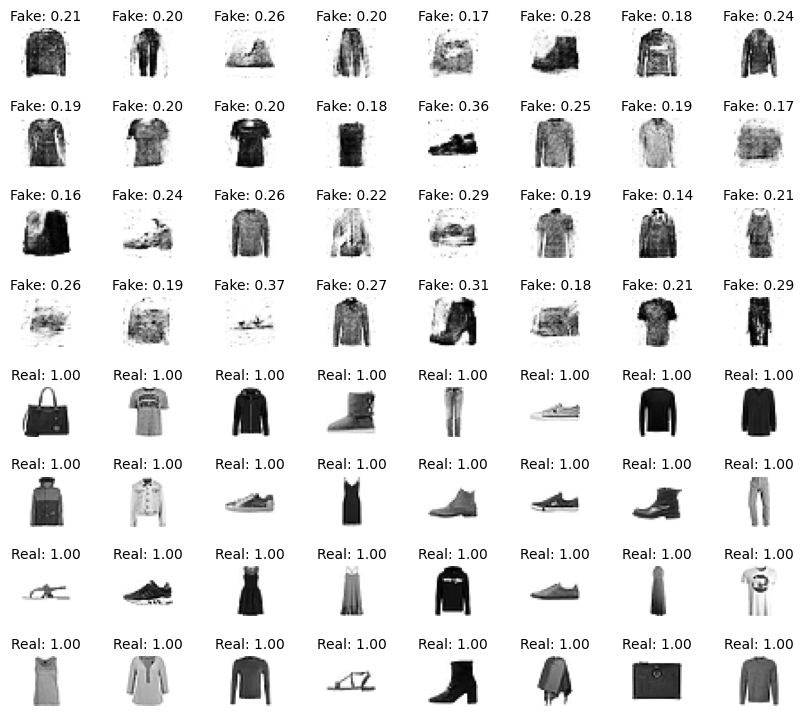

In [21]:
# we again make a check and visualize generated and real images along with the output of the
# discriminator with its predicted probability of the image being real
visualize_fake_vs_real(generator2, discriminator2, test_dataset, latent_dim=100, num_images=32)


# **3) Variatonal Autoencoder (VAE) model**
## - We will use the Functional API
## - Apart from the train set we will also need a validation set

In [22]:
# for VAEs we will need a train and a validation set, so we create the dataset again and make
# the appropriate splits
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

batch_size = 32

# we make sure inputs are normalized and reshaped properly
X_train = X_train.astype(np.float32).reshape(-1, 28, 28, 1)
X_valid = X_valid.astype(np.float32).reshape(-1, 28, 28, 1)

# We create the datasets
# Firstly we prepare train dataset: (input, target) = (image, image)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train))
train_dataset = train_dataset.shuffle(buffer_size=1000, seed=42)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# and then the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid, X_valid))
val_dataset = val_dataset.batch(batch_size).prefetch(1)

In [23]:
# again we define the save directory and create the last_epoch.txt file
save_dir_vae = "/content/drive/MyDrive/vae_outputs"
epoch_file_path_vae = os.path.join(save_dir_vae, 'last_epoch.txt')
os.makedirs(save_dir_vae, exist_ok=True)


In [24]:
# we define the Sampling class (layer) that is needed in Variational Autoencoders
# Sampling Layer which also adds KL Divergence loss
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        z = z_mean + tf.exp(0.5 * z_log_var) * eps

        # Compute KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )
        self.add_loss(tf.reduce_mean(kl_loss) / 784.)
        return z


# Encoder part
tf.random.set_seed(42)  # again we set the seed for reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=(28, 28, 1))
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=inputs, outputs=[codings_mean, codings_log_var, codings])


# Decoder part
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=decoder_inputs, outputs=outputs)


# we combine the Encoder and Decoder
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=inputs, outputs=reconstructions)

In [25]:
# we compile the model
variational_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())

In [26]:
# again we set seed to 42
tf.random.set_seed(42)

# we generate fixed latent vectors for better monitoring of the training
latent_dim = variational_decoder.input_shape[1]
num_images = 32
fixed_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))


# we define a train function
def train_vae(model, encoder, decoder, epochs, batch_size, save_dir,
              train_data, val_data=None):
    os.makedirs(save_dir, exist_ok=True)

    epoch_file_path = os.path.join(save_dir, 'last_epoch.txt')

    # Load last epoch number
    if os.path.exists(epoch_file_path):
        with open(epoch_file_path, "r") as f:
            last_epoch = int(f.read())
    else:
        last_epoch = 0

    print(f"Resuming training from epoch {last_epoch + 1}...")

    # Load weights
    weights_file = os.path.join(save_dir, f'vae_epoch_{last_epoch}.weights.h5')
    if os.path.exists(weights_file):
        print(f"Loading weights from {weights_file}")
        model.load_weights(weights_file)
    else:
        print("No weights found, starting from scratch.")

    # Training loop
    for epoch in range(last_epoch + 1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        model.fit(train_data, epochs=1, batch_size=batch_size, validation_data=val_data)

        # Save weights and generate images every epoch
        # Save model weights
        weights_file = os.path.join(save_dir, f'vae_epoch_{epoch}.weights.h5')
        model.save_weights(weights_file)

        # Generate and save samples
        generate_and_save_images(decoder, epoch, save_dir)

        print(f"Saved weights and generated samples at epoch {epoch}")

        # Save current epoch to file (always update progress)
        with open(epoch_file_path, "w") as f:
            f.write(str(epoch))


# we define another function that generates and saves the generated images
def generate_and_save_images(decoder, epoch, save_dir, latent_vectors=fixed_latent_vectors, rows=4, cols=8):
    num_images = rows * cols

    # Decode latent vectors to images using fixed latent vectors
    generated_images = decoder(latent_vectors).numpy()

    if generated_images.shape[-1] == 1:
        generated_images = np.squeeze(generated_images, axis=-1)

    os.makedirs(save_dir, exist_ok=True)
    image_path = os.path.join(save_dir, f"vae_epoch_{epoch}.png")

    plt.figure(figsize=(20/3, 10/3))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 8, i + 1)
        plt.imshow(generated_images[i], cmap='binary')
        plt.axis('off')
    plt.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    # Save to file
    image_path = os.path.join(save_dir, f"vae_epoch_{epoch}.png")
    plt.savefig(image_path)
    plt.close()

    # Display in notebook
    from IPython.display import Image, display
    display(Image(filename=image_path))

In [27]:
train_vae(model=variational_ae, encoder=variational_encoder, decoder=variational_decoder,
    epochs=100, batch_size=32, save_dir=save_dir_vae, train_data=train_dataset,
          val_data=val_dataset)

Resuming training from epoch 101...
Loading weights from /content/drive/MyDrive/vae_outputs/vae_epoch_100.weights.h5


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# **4) Diffusion model**

## - Here we use the architecture of diffusion models
## - We follow the U-Net-style structure: downsampling, skip connections, upsampling

In [29]:
# we again create the train, test and validation sets
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [30]:
# we create a smooth cosine-based noise schedule for the diffusion model
# returns alpha, cumulative alpha, and beta arrays for timesteps 0 to T
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

# we set the seed for reproducibility
np.random.seed(42)
# we set the T (number of time steps) to a high value so as to achieve better quality
# at the cost of more time for the generation of the images
T = 4000
alpha, alpha_cumprod, beta = variance_schedule(T)

In [31]:
# we add noise to a batch of inputs X at random timesteps t using the precomputed schedule
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

In [32]:
# we wrap data into a pipeline: batching, shuffling, noise prep, and prefetching
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

# we set the seed for reproducibility on CPU
tf.random.set_seed(42)
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

In [33]:
# we set the embed size
embed_size = 64

# we create a class (custom time encoding layer) that provides sinusoidal time-step embeddings
class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)

        # here we create a positional encoding matrix of shape (T+1, embed_size)
        # Rows: timesteps 0 to T, Columns: alternating sin and cos functions
        assert embed_size % 2 == 0, "embed_size must be even" # needed for alternating sin/cos
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T

        # Store the precomputed embeddings as a constant tensor
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        # Fetch the precomputed time encodings for the given timestep indices
        return tf.gather(self.time_encodings, inputs)


- This layer encodes each timestep t ∈ [0, T] into a fixed embedding using sine/cosine waves.
- It helps the model know “when” it is in the diffusion process.
- The result is a [batch_size, embed_size] tensor when given a [batch_size] input of timestep indices.

In [34]:
# we create a function that builds the diffusion model
def build_diffusion_model():
    # Inputs: noisy image and timestep
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    # Time encoding using the class we created earlier
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16

    # Initial convolution after zero-padding (to preserve border in later cropping)
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    # we inject timestep embedding into the feature map
    time = tf.keras.layers.Dense(dim)(time_enc)  # project time to match channel dim
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # broadcast to spatial dimensions

    skip = Z  # for residual skip connections
    cross_skips = []  # to store skip connections

    # Downsampling path (Encoder)
    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        # here we will use SeparableConv2D which has similar behavior with the Conv2D layer
        # but is more efficient
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        # Downsampling via max-pooling with skip connection
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2, padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link]) # residual connection

        # we inject timestep again at this resolution
        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z   # update for next skip connection


    # Upsampling path (Decoder)
    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        # Residual skip connection from previous layer
        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        # Inject timestep again
        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        # U-Net skip connection: concatenate with matching encoder feature map
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z  # update skip for next iteration

    # Final output layer (predict noise to remove) and crop to original 28×28
    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

In [35]:
# now we create a function that generates images from pure noise using the reverse
# diffusion process

def generate(model, batch_size=32, initial_noise=None):
    tf.random.set_seed(42) # Ensure reproducibility

    # Step 1: Start from noise (or use provided noise)
    if initial_noise is not None:
        X = tf.identity(initial_noise)  # clone the given noise tensor
    else:
        X = tf.random.normal([batch_size, 28, 28, 1])  # sample standard Gaussian noise

    # Step 2: Reverse diffusion loop (from T-1 to 1)
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")

        # Add noise only if t > 1. Last step uses zeros to end with a clean image
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))

        # Predict the noise that was added at timestep t
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        # Reverse the noise step using the DDPM update rule
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X   # Final denoised image (sample)

In [36]:
# now another function that generates and saves images using this model
def save_generated_images(model, epoch, count=32):
    generated_images = generate(model, batch_size=count, initial_noise=fixed_noise[:count])
    generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]

    plt.figure(figsize=(20/3, 10/3))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 8, i + 1)
        plt.imshow(generated_images[i], cmap='binary')
        plt.axis('off')
    plt.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    # Save to file
    image_path = os.path.join(save_dir_diffusion, f"diffusion_epoch_{epoch}.png")
    plt.savefig(image_path)
    plt.show()
    plt.close()


    # we define the save directory and create the last_epoch.txt file as before
save_dir_diffusion = "/content/drive/MyDrive/diffusion_outputs"
os.makedirs(save_dir_diffusion, exist_ok=True)
epoch_file_path_diffusion = os.path.join(save_dir_diffusion, 'last_epoch.txt')

In [37]:
# we set the seed to ensure reproducibility on the CPU
tf.random.set_seed(42)
# we build and compile the diffusion model
diffusion_model = build_diffusion_model()
diffusion_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Nadam())

# we check and load previous epoch (if it exists)
if os.path.exists(epoch_file_path_diffusion):
    with open(epoch_file_path_diffusion, "r") as f:
        last_epoch = int(f.read())
else:
    last_epoch = 0

# we load model weights if they exist
model_weights_file = os.path.join(save_dir_diffusion, f'diffusion_epoch_{last_epoch}.weights.h5')
if os.path.exists(model_weights_file):
    print(f"Loading weights from epoch {last_epoch}")
    diffusion_model.load_weights(model_weights_file)
else:
    print("No saved weights found. Starting from scratch.")

# we set a fixed seed to obtain a fixed noise for reproducibility across epochs
tf.random.set_seed(42)
np.random.seed(42)
fixed_noise = tf.random.normal([32, 28, 28, 1])

# Main Training Loop
epochs_to_train = 127

for epoch in range(last_epoch + 1, epochs_to_train + 1):
    print(f"Epoch {epoch}/{epochs_to_train}")

    diffusion_model.fit(train_set, validation_data=valid_set, epochs=1)

    # Save model weights
    diffusion_model_weights_file = os.path.join(save_dir_diffusion, f'diffusion_epoch_{epoch}.weights.h5')
    diffusion_model.save_weights(diffusion_model_weights_file)

    # Generate & show/save images
    print(f"Generating sample images at epoch {epoch}...")
    save_generated_images(diffusion_model, epoch)

    # Save last epoch to file for resuming later
    with open(epoch_file_path_diffusion, "w") as f:
        f.write(str(epoch))

Loading weights from epoch 127


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 175 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Evaluation of the four models:
##- **GAN**:
###Fast to train / Moderate training stability / Moderate image quality / Moderate image diversity / Low computational cost
##- **DCGAN**:
###Slow training / Low training stability / Improved image quality / Better image diversity / High computational cost
##- **VAE**:
###Fast to train / High training stability / Good image quality (but blurrier images) / Good image diversity / Low computational cost
##- **Diffusion model**:
###Very slow training / High training stability / High image quality / Good image diversity / High computational cost